<a href="https://colab.research.google.com/github/Arindam-97/Sliced-Normal/blob/main/Python/Sliced_Normals_(General).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal as mvt
from scipy.stats import norm
from scipy.stats import truncnorm
from scipy.stats import bernoulli
import scipy.integrate as integrate
from scipy.stats import kstest
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.optimize import direct
from scipy.linalg import block_diag
import seaborn as sns
from itertools import combinations_with_replacement
from itertools import product
import os
import pickle
from scipy.stats import chisquare
import matplotlib.pyplot as plt
import scipy

In [6]:
# Clone git repo
! git clone https://github.com/Arindam-97/Sliced-Normal/
os.chdir('Sliced-Normal/Python')

Cloning into 'Sliced-Normal'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 48 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (48/48), 439.48 KiB | 1.85 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [7]:
# import codes for sliced normals
import SN_General as SN

## Get Data

In [ ]:
with open('dependency_data.pkl', 'rb') as f:
    data = pickle.load(f)
data.head()

,X_1,X_2,X_3,X_4,X_5
0,0.267176,-0.545819,-0.638412,0.678775,-0.024864
1,0.338370,-0.243975,-1.089105,-0.063481,-0.172964
2,-0.842659,-0.500572,0.732940,-3.151521,-3.944767
3,1.495279,0.636840,-1.862289,0.258594,0.236612
4,-0.129121,-0.764270,-0.231473,-3.110318,-1.243725


# Usage (Bivariate Example)

### Set Parameters

In [ ]:
'''
(DataFrame)   'data'   -> Data
(double)      'd'      -> Maximum degree of polynomials to be used
(double)      'c_bound -> The integration constant (c) is capped at this value.
                         If estimated c < c_bound, then c is forcefully made equal to c_bound.
(numpy.array) 'low'    -> Vector of lower bounds of integration
(numpy.array) 'high'   -> Vector of lower bounds of integration
                          Note: high and low characterize the region \Delta

(integer)     'niter'  -> Number of times the optimizer is invoked.
                          We start from different starting points and optimize to improve chances of hitting the global maxima
                          Default: 20

(double)      'ftol'    -> Tolerence for optimizer
(double)      'tol'     -> Tolerence for optimizer
'''


data = data[['X_1','X_2']]
d = 2
c_bound = 1e-5

low = np.array(data.min())
high = np.array(data.max())

niter = 10
ftol = 1e-2
tol = 1e-2


<Axes: xlabel='X_1', ylabel='X_2'>

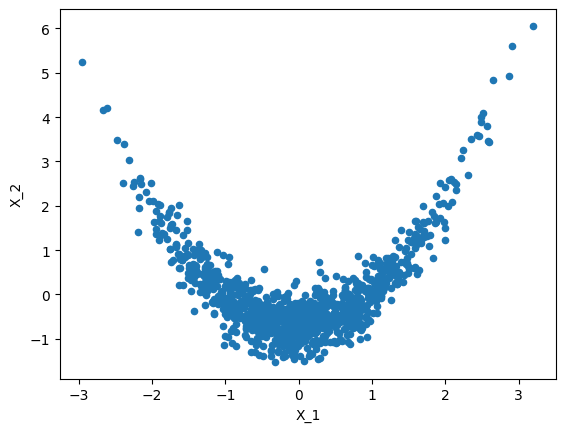

In [ ]:
data.plot.scatter(x = 'X_1', y = 'X_2')

### Notes on prints

- **Initial Vector**: Optimization starts here. Corresponds to Feature space estimates $(\mu_0,\Sigma_0)$
- **Initial obj Value**: Log likelihood at $(\mu_0,\Sigma_0)$
- **Initail c (Randomized)**: Initail value of the integration constant. 'Randomized' refres to the fact that Monte-Carlo Integration was used here.
- **Optimizing**: Refers to the start of the optimization procedure. It randomly prints some of the objective values and corresponding $c$ as the optimiztion progresses.

In [ ]:
# approx run time: 1 minute

mu, Sigma = SN.get_Data_Space_Estimates(data,d, c_bound,low,high, niter, ftol = 1e-2, tol = 1e-2)

Initail Vector:  [-6.39488462e-17  1.00000000e+00  1.55431223e-17  9.93556295e-02
  1.00000000e+00  1.00050038e+00  1.94895651e+00  9.94053446e-02
  4.06730436e-01  1.26788203e+00  1.96859866e+00  1.08298997e-01
  5.95609648e-01  1.95852305e-01  9.89641807e-01  1.17576009e+00
 -8.15744930e-02  1.39467875e+00 -8.49883950e-03  4.61998518e-01]
Initail obj Value :  -2518.3894822646453
Initail c (Randomized):  0.010188245136103218
Optimizing 

obj_value: -3188.2056171100303  c: 0.003201448731307516
obj_value: -2390.4844186832615  c: 0.007584776982367477
obj_value: -1981.814619844713  c: 0.001039431285393071
obj_value: -1869.8389069064563  c: 0.00016733169910177175
obj_value: -2269.4203464059556  c: 0.0001583024074380916
obj_value: -2114.261394667637  c: 0.00017147122688368895
obj_value: -2925.9007492838286  c: 0.00015501421708452495
obj_value: -2391.9387290556033  c: 9.41285261124141e-05
obj_value: -1873.547556735407  c: 0.00014703741584364973
obj_value: -1865.8140395127118  c: 0.0001464132

# Plots

### Heatmap

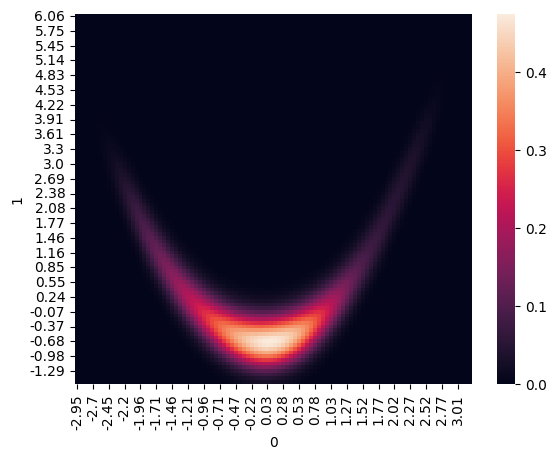

In [ ]:
A = np.random.uniform(low,high, size = (100000,len(low)))
Feature_Space_Samples = SN.Features(pd.DataFrame(A),d=d)
c = SN.get_c(mu, Sigma,d, low,high, Feature_Space_Samples)


SN.get_heatmap(mu,Sigma, low , high,c,d)

### Contour Plots

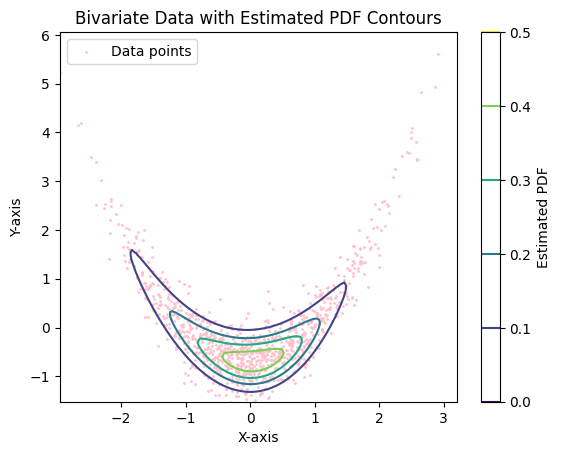

In [ ]:
SN.get_contour(data, mu,Sigma, low =low, high = high,c = c, d = d)

## Log-Likelihood and AIC/BIC

In [ ]:
Features = SN.Features(data,d=d)
LL = SN.get_likelihood(Features,mu,Sigma,d,low,high ,Feature_Space_Samples,c_bound)
LL

-1863.2153410597723

In [ ]:
D = len(mu)
k = D + D*(D+1)/2 # Total number of parametrs used

AIC = 2*k - 2*LL
BIC = k*np.log(len(Features)) - 2*LL

(k, BIC)

(20.0, 3864.585787699187)

# Usage 2: Trivariate Example

In [ ]:
with open('dependency_data.pkl', 'rb') as f:
    data = pickle.load(f)
data.head()

,X_1,X_2,X_3,X_4,X_5
0,0.267176,-0.545819,-0.638412,0.678775,-0.024864
1,0.338370,-0.243975,-1.089105,-0.063481,-0.172964
2,-0.842659,-0.500572,0.732940,-3.151521,-3.944767
3,1.495279,0.636840,-1.862289,0.258594,0.236612
4,-0.129121,-0.764270,-0.231473,-3.110318,-1.243725


### Set Parameters

In [ ]:
'''
(DataFrame)   'data'   -> Data
(double)      'd'      -> Maximum degree of polynomials to be used
(double)      'c_bound -> The integration constant (c) is capped at this value.
                         If estimated c < c_bound, then c is forcefully made equal to c_bound.
(numpy.array) 'low'    -> Vector of lower bounds of integration
(numpy.array) 'high'   -> Vector of lower bounds of integration
                          Note: high and low characterize the region \Delta

(integer)     'niter'  -> Number of times the optimizer is invoked.
                          We start from different starting points and optimize to improve chances of hitting the global maxima
                          Default: 20

(double)      'ftol'    -> Tolerence for optimizer
(double)      'tol'     -> Tolerence for optimizer
'''


data = data[['X_1','X_2','X_3']]
d = 2
c_bound = 1e-7

low = np.array(data.min())
high = np.array(data.max())

niter = 10
ftol = 1e-2
tol = 1e-2


<Axes: xlabel='X_1', ylabel='X_3'>

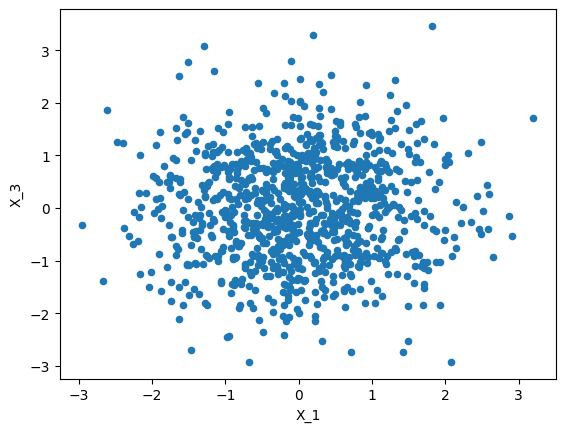

In [ ]:
data.plot.scatter(x = 'X_1', y = 'X_3')

### Notes on prints

- **Initial Vector**: Optimization starts here. Corresponds to Feature space estimates $(\mu_0,\Sigma_0)$
- **Initial obj Value**: Log likelihood at $(\mu_0,\Sigma_0)$
- **Initail c (Randomized)**: Initail value of the integration constant. 'Randomized' refres to the fact that Monte-Carlo Integration was used here.
- **Optimizing**: Refers to the start of the optimization procedure. It randomly prints some of the objective values and corresponding $c$ as the optimiztion progresses.

In [ ]:
# approx run time: 1 minute 20 secs

mu, Sigma = SN.get_Data_Space_Estimates(data,d, c_bound,low,high, niter, ftol = 1e-2, tol = 1e-2)

Initail Vector:  [-3.10862447e-18  1.00000000e+00 -6.39488462e-17 -8.30448152e-04
  1.00000000e+00  1.55431223e-17  2.38447256e-02  9.93556295e-02
  1.00000000e+00  1.00050038e+00  3.78018149e-02 -8.30863687e-04
  3.89644103e-02  2.42237218e-02  2.38566569e-02  1.80879163e-02
 -7.24998122e-04  4.50030559e-03  1.39401924e+00  2.79876447e-02
  1.77567492e-02  5.42639930e-03  1.23349388e-02  3.06425446e-02
  3.90085066e-03  2.09947057e-02  1.00010850e+00  2.37686685e-02
  1.94958846e+00  9.91189264e-02 -1.56777485e-03  4.06780042e-01
  1.26779504e+00  1.00353477e+00  1.38741261e-01 -4.21497580e-03
  1.03308556e-01  5.36792206e-02  1.34730753e-02  1.96291917e+00
  1.08834231e-01  1.41352414e-02  5.93356825e-01  1.95031328e-01
  9.89238340e-01  2.77537504e-03  1.17647558e+00 -8.15605071e-02
  1.00882121e+00  2.41205138e-02 -3.64408704e-04  1.39377365e+00
 -8.39696314e-03  4.61893301e-01]
Initail obj Value :  -8269.815176096345
Initail c (Randomized):  0.0002975410310319173
Optimizing 

obj_

# Plots

In [ ]:
A = np.random.uniform(low,high, size = (100000,len(low)))
Feature_Space_Samples = SN.Features(pd.DataFrame(A),d=d)
c = SN.get_c(mu, Sigma,d, low,high, Feature_Space_Samples)

### Contour Plots

Since we have three variables, we need to get the bivariate marginals before plots

In [ ]:

xaxis = np.linspace(low[0], high[0], 100)
yaxis = np.linspace(low[1], high[1], 100)
zaxis = np.linspace(low[2], high[2], 100)

x,y, z = np.meshgrid(xaxis, yaxis, zaxis)
mesh = pd.DataFrame()
mesh[data.columns[0]] = x.reshape(-1)
mesh[data.columns[1]] = y.reshape(-1)
mesh[data.columns[2]] = z.reshape(-1)

mesh['pdf'] = SN.Estimated_pdf(mesh,mu,Sigma,c,d=d)

mesh.head()

,X_1,X_2,X_3,pdf
0,-2.949824,-1.520741,-2.922680,1.343350e-65
1,-2.949824,-1.520741,-2.858196,3.255216e-65
2,-2.949824,-1.520741,-2.793713,7.653888e-65
3,-2.949824,-1.520741,-2.729229,1.748500e-64
4,-2.949824,-1.520741,-2.664745,3.885855e-64


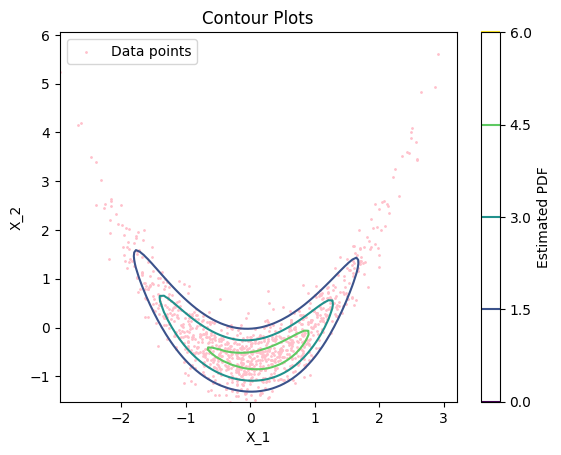

In [ ]:
a = 'X_1'
b = 'X_2'

temp = mesh.groupby([a,b], as_index = False).sum()
SN.get_contour_from_mesh(data[[a,b]], temp[[a,b,'pdf']], (100,100),'Contour Plots' ,x = a, y = b)

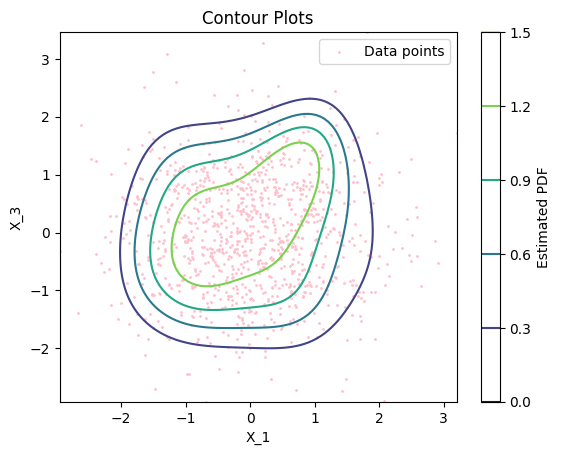

In [ ]:
a = 'X_1'
b = 'X_3'

temp = mesh.groupby([a,b], as_index = False).sum()
SN.get_contour_from_mesh(data[[a,b]], temp[[a,b,'pdf']], (100,100),'Contour Plots' ,x = a, y = b)

## Log-Likelihood and AIC/BIC

In [ ]:
Features = SN.Features(data,d=d)
LL = SN.get_likelihood(Features,mu,Sigma,d,low,high ,Feature_Space_Samples,c_bound)
LL

-3485.664374648172

In [ ]:
D = len(mu)
k = D + D*(D+1)/2 # Total number of parametrs used

AIC = 2*k - 2*LL
BIC = k*np.log(len(Features)) - 2*LL

(k, BIC)

(54.0, 7344.347534361379)